In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training'
/content/drive/MyDrive/Colab Notebooks/WRI-Hackathon/python_scripts/training


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys
# sys.path.insert(0, '../models')
# from krs_inflow_model import SimpleMLP

In [ ]:
df = pd.read_csv('../dataset/reservoir_rainfall_dataset.csv')
df = df[df['RESERVOIR'] == 'K.R.S']
df.head()

,FLOW_DATE,RESERVOIR,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS,YEAR,MONTH,DATE,DAY,RAINFALL,SEASON
3309,2011-01-01,K.R.S,46.42,122.59,2029.0,2000.0,2011,1,1,0,0.0226,WINTER
3310,2012-01-01,K.R.S,40.97,118.33,4924.0,2488.0,2012,1,1,0,0.0161,WINTER
3311,2014-01-01,K.R.S,38.58,116.33,1885.0,1994.0,2014,1,1,0,0.1065,WINTER
3312,2015-01-01,K.R.S,43.26,120.17,1631.0,4419.0,2015,1,1,0,0.0065,WINTER
3313,2016-01-01,K.R.S,27.89,106,703.0,1965.0,2016,1,1,0,0.0097,WINTER


In [ ]:
df.shape

(3308, 12)

In [ ]:
df = df.drop(columns=['FLOW_DATE', 'RESERVOIR', 'PRESENT_STORAGE_TMC', 'RES_LEVEL_FT', 'OUTFLOW_CUECS', 'MONTH', 'DATE'])
df.head()

,INFLOW_CUSECS,YEAR,DAY,RAINFALL,SEASON
3309,2029.0,2011,0,0.0226,WINTER
3310,4924.0,2012,0,0.0161,WINTER
3311,1885.0,2014,0,0.1065,WINTER
3312,1631.0,2015,0,0.0065,WINTER
3313,703.0,2016,0,0.0097,WINTER


In [ ]:
day_le = LabelEncoder().fit(df['DAY'].unique())
season_le = LabelEncoder().fit(df['SEASON'].unique())

In [ ]:
train_df = df[df['YEAR'] < 2019]
val_df = df[df['YEAR'] >= 2019]

train_df.drop(columns='YEAR', inplace=True)
val_df.drop(columns='YEAR', inplace=True)
train_df.shape, val_df.shape

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


((2613, 4), (695, 4))

In [ ]:
class InflowDataset(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __getitem__(self, index):
        inflow, day, rainfall, season = self.df.iloc[index].values
        
        day_transformed = day_le.transform([day])
        season_transformed = season_le.transform([season])
        return (torch.tensor(day_transformed[0]), torch.tensor(season_transformed[0]), torch.FloatTensor([rainfall])), torch.FloatTensor([inflow])
    
    def __len__(self):
        return self.df.shape[0]

In [ ]:
train_ds = InflowDataset(train_df)
val_ds = InflowDataset(val_df)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=32, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
class SimpleMLP(nn.Module):
    def __init__(self, nday, nseason):
        super().__init__()
        self.day_emb = nn.Embedding(num_embeddings=nday, embedding_dim=128)
        self.season_emb = nn.Embedding(num_embeddings=nseason, embedding_dim=128)
        self.rainfall = nn.Sequential(
            nn.Linear(in_features=1, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU()
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=128*3, out_features=512),
            nn.LeakyReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(),
            nn.Linear(in_features=256, out_features=64),
            nn.LeakyReLU(),
            nn.Linear(in_features=64, out_features=1)
        )
    
    def forward(self, x_day, x_season, x_rainfall):
        day_out = self.day_emb(x_day)
        season_out = self.season_emb(x_season)
        rainfall_out = self.rainfall(x_rainfall)

        return self.output(torch.cat([day_out, season_out, rainfall_out], axis=1))

In [ ]:
def train(model, epochs, lr):
    opt = Adam(model.parameters(), lr=lr)
    # schd = ReduceLROnPlateau(opt, threshold=1000)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        train_loss = 0
        val_loss = 0

        model.train()
        for xb, yb in train_dl:
            x_day = xb[0].cuda()
            x_season = xb[1].cuda()
            x_rainfall = xb[2].cuda()
            yb = yb.cuda()

            y_hat = model(x_day, x_season, x_rainfall)
            loss = criterion(y_hat, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for xb, yb in val_dl:
                x_day = xb[0].cuda()
                x_season = xb[1].cuda()
                x_rainfall = xb[2].cuda()
                yb = yb.cuda()

                y_hat = model(x_day, x_season, x_rainfall)
                loss = criterion(y_hat, yb)

                val_loss += loss.item()
        
        # schd.step(val_loss / len(val_dl))
        
        print(f'Epoch - {epoch+1} | Train Loss - {round(train_loss / len(train_dl), 2)} | Val Loss - {round(val_loss / len(val_dl), 2)}')

In [ ]:
model = SimpleMLP(len(day_le.classes_), len(season_le.classes_)).cuda()

In [ ]:
train(model, epochs=50, lr=1e-03)

Epoch - 1 | Train Loss - 84436525.76 | Val Loss - 137781141.67
Epoch - 2 | Train Loss - 62603692.02 | Val Loss - 139002072.19
Epoch - 3 | Train Loss - 62849485.86 | Val Loss - 136177947.13
Epoch - 4 | Train Loss - 59296859.77 | Val Loss - 135484196.12
Epoch - 5 | Train Loss - 58164520.24 | Val Loss - 145208589.42
Epoch - 6 | Train Loss - 57063472.65 | Val Loss - 134704708.04
Epoch - 7 | Train Loss - 56954650.91 | Val Loss - 134824098.46
Epoch - 8 | Train Loss - 55037112.75 | Val Loss - 133900516.32
Epoch - 9 | Train Loss - 54903535.76 | Val Loss - 133635790.28
Epoch - 10 | Train Loss - 53770718.16 | Val Loss - 132826520.48
Epoch - 11 | Train Loss - 51370834.59 | Val Loss - 131306446.49
Epoch - 12 | Train Loss - 52797793.08 | Val Loss - 135387550.51
Epoch - 13 | Train Loss - 51470677.95 | Val Loss - 130516729.21
Epoch - 14 | Train Loss - 51037346.68 | Val Loss - 137773775.95
Epoch - 15 | Train Loss - 50094189.38 | Val Loss - 130456581.31
Epoch - 16 | Train Loss - 50728672.41 | Val Loss 

In [ ]:
train(model, epochs=200, lr=1e-04)

Epoch - 1 | Train Loss - 40743644.02 | Val Loss - 145776614.01
Epoch - 2 | Train Loss - 39888700.2 | Val Loss - 143377094.68
Epoch - 3 | Train Loss - 39722187.05 | Val Loss - 148119372.72
Epoch - 4 | Train Loss - 39405918.58 | Val Loss - 145497485.19
Epoch - 5 | Train Loss - 39514138.87 | Val Loss - 144601950.02
Epoch - 6 | Train Loss - 39431635.04 | Val Loss - 148364588.44
Epoch - 7 | Train Loss - 39559527.9 | Val Loss - 147306319.95
Epoch - 8 | Train Loss - 39517400.08 | Val Loss - 146372208.14
Epoch - 9 | Train Loss - 39625081.81 | Val Loss - 147657541.91
Epoch - 10 | Train Loss - 39286659.82 | Val Loss - 148063755.32
Epoch - 11 | Train Loss - 39124010.74 | Val Loss - 147623947.42
Epoch - 12 | Train Loss - 40323448.5 | Val Loss - 147567494.55
Epoch - 13 | Train Loss - 39361048.84 | Val Loss - 149710603.89
Epoch - 14 | Train Loss - 39397418.63 | Val Loss - 151686264.74
Epoch - 15 | Train Loss - 39029798.98 | Val Loss - 146938748.5
Epoch - 16 | Train Loss - 38885272.11 | Val Loss - 14

In [ ]:
train(model, epochs=500, lr=1e-06)

Epoch - 1 | Train Loss - 27757127.95 | Val Loss - 236676999.86
Epoch - 2 | Train Loss - 27732931.41 | Val Loss - 236184315.53
Epoch - 3 | Train Loss - 27626928.63 | Val Loss - 235877484.44
Epoch - 4 | Train Loss - 27555161.63 | Val Loss - 235451729.28
Epoch - 5 | Train Loss - 27564012.14 | Val Loss - 234947096.64
Epoch - 6 | Train Loss - 27815215.28 | Val Loss - 234632219.21
Epoch - 7 | Train Loss - 27550626.47 | Val Loss - 234262501.22
Epoch - 8 | Train Loss - 27643462.44 | Val Loss - 233972891.38
Epoch - 9 | Train Loss - 27527742.51 | Val Loss - 233632688.62
Epoch - 10 | Train Loss - 27475887.75 | Val Loss - 233304707.62
Epoch - 11 | Train Loss - 27618810.88 | Val Loss - 233117381.28
Epoch - 12 | Train Loss - 27473688.2 | Val Loss - 232730470.8
Epoch - 13 | Train Loss - 27559377.62 | Val Loss - 232575851.17
Epoch - 14 | Train Loss - 27482212.91 | Val Loss - 232236671.05
Epoch - 15 | Train Loss - 27734991.91 | Val Loss - 232045053.47
Epoch - 16 | Train Loss - 27468936.37 | Val Loss - 

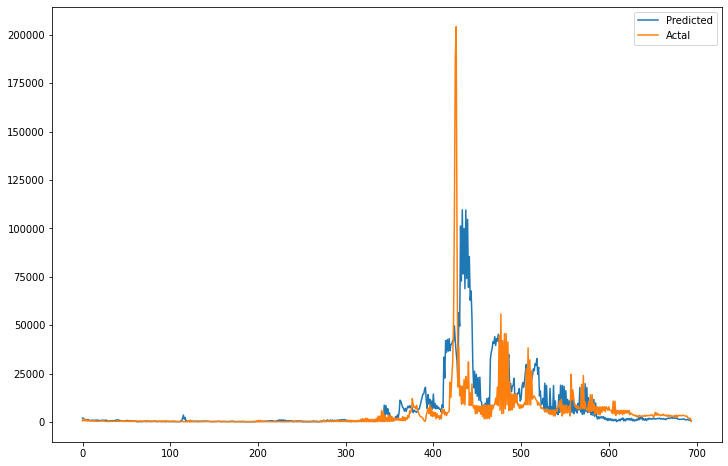

In [ ]:
y_actual, y_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        x_day = xb[0].cuda()
        x_season = xb[1].cuda()
        x_rainfall = xb[2].cuda()

        y_hat = model(x_day, x_season, x_rainfall)

        y_actual += yb.data.tolist()
        y_pred += y_hat.cpu().data.tolist()

y_actual = np.array(y_actual).flatten()
y_pred = np.array(y_pred).flatten()

plt.figure(figsize=(12, 8))
plt.plot(y_pred, label='Predicted')
plt.plot(y_actual, label='Actal')
plt.legend()
plt.show()

In [ ]:
def pred(df):
    df = df.copy().drop(columns=['YEAR'])
    pred_ds = InflowDataset(df)
    pred_dl = DataLoader(pred_ds, batch_size=len(pred_ds))

    model.eval()
    with torch.no_grad():
        for x, y in pred_dl:
            x_day = x[0].cuda()
            x_season = x[1].cuda()
            x_rainfall = x[2].cuda()
            y_hat = model(x_day, x_season, x_rainfall)

    return y_hat.data.cpu().view(-1).tolist()

In [ ]:
model_test_df = df.copy()
model_test_df['Predicted_Inflow'] = pred(model_test_df)
model_test_df[:10]

,INFLOW_CUSECS,YEAR,DAY,RAINFALL,SEASON,Predicted_Inflow
3309,2029.0,2011,0,0.0226,WINTER,1888.077637
3310,4924.0,2012,0,0.0161,WINTER,1924.417358
3311,1885.0,2014,0,0.1065,WINTER,1276.901123
3312,1631.0,2015,0,0.0065,WINTER,1941.684082
3313,703.0,2016,0,0.0097,WINTER,1935.423950
3314,264.0,2017,0,1.8548,WINTER,-14.878106
3315,291.0,2018,0,0.0000,WINTER,1963.426392
3316,581.0,2019,0,0.0000,WINTER,1963.426392
3317,1388.0,2020,0,0.0000,WINTER,1963.426392
3318,3084.0,2011,1,0.0226,WINTER,1808.066284


In [ ]:
avg_daily_pred_inflow = model_test_df.groupby('DAY')['Predicted_Inflow'].mean().values
avg_daily_actual_inflow = model_test_df.groupby('DAY')['INFLOW_CUSECS'].mean().values
avg_daily_actual_rainfall = model_test_df.groupby('DAY')['RAINFALL'].mean().values

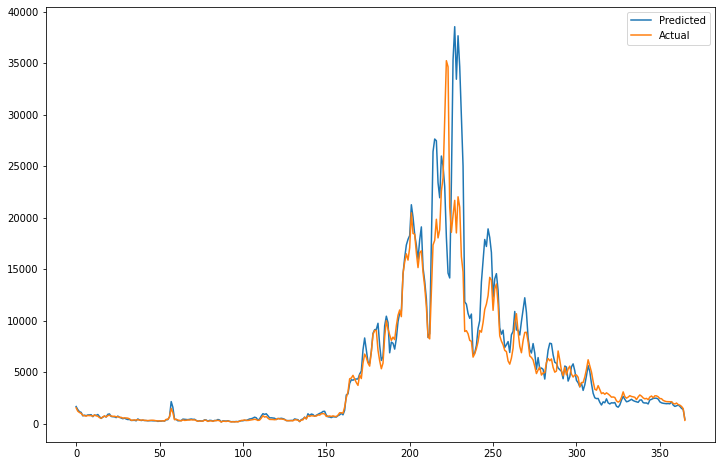

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow, label='Predicted')
plt.plot(avg_daily_actual_inflow, label='Actual')
plt.legend()
plt.show()

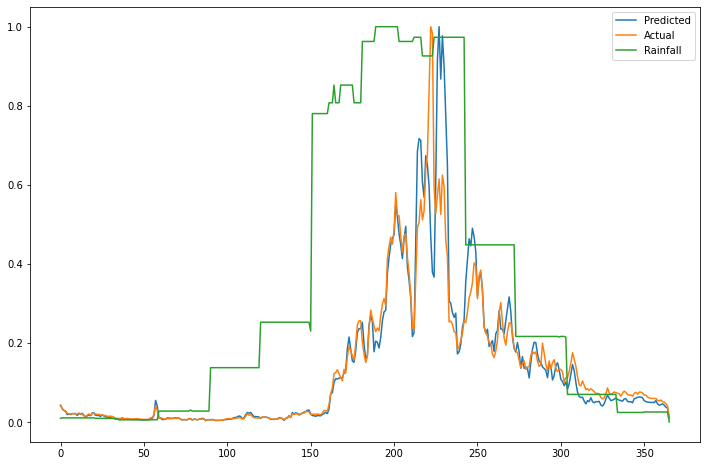

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(avg_daily_pred_inflow / avg_daily_pred_inflow.max(), label='Predicted')
plt.plot(avg_daily_actual_inflow / avg_daily_actual_inflow.max(), label='Actual')
plt.plot(avg_daily_actual_rainfall / avg_daily_actual_rainfall.max(), label='Rainfall')

plt.legend()
plt.show()

In [ ]:
((model_test_df['INFLOW_CUSECS'] - model_test_df['Predicted_Inflow']) ** 2).mean() ** .5

8408.933379273547

In [ ]:
torch.save(model.state_dict(), 'krs_inflow_model_state.pth')